In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
import xgboost as xgb
from functools import partial
from sklearn.metrics import confusion_matrix, roc_curve, auc
import json
import pickle
from functools import partial
from sklearn.metrics import mean_squared_error
import hiplot
import csv

data_dir = "../../data/unziped_data/"

In [2]:
data_for_training = '../../data/unziped_data/'
df_FTP_SABER11_20141 = pd.read_csv(data_for_training+'FTP_SABER11_20141.TXT', delimiter='¬')
data_FTP_SABER11_20141 = df_FTP_SABER11_20141.values
print(df_FTP_SABER11_20141.values.shape)

/home/lfardilap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  


(24893, 136)


In [3]:
df_FTP_SABER11_20141['COLE_CODIGO_ICFES']

0        19364
1        19364
2        19364
3        19364
4        19364
         ...  
24888    88591
24889    88591
24890    88591
24891    88591
24892    88591
Name: COLE_CODIGO_ICFES, Length: 24893, dtype: int64

In [11]:
#Open data with pandas
data_for_training = '../../data/Data_For_Training/'
data = pd.read_csv(data_for_training+'icfes_20141.csv')

notasz  = [c for c in data.columns.values if c.startswith('NOTA_Z')]
deciles = [c for c in data.columns.values if c.startswith('DECILE')]
puntajes= [c for c in data.columns.values if c.startswith('PUNT')]

# lista de las columnas con las caracteristicas a predecir
labels_names = notasz + deciles

# lista de las columnas que se van a omitir de las caracteristicas
vars_2_omit = (
    [
        "PUNT_MATEMATICAS",
        "PUNT_CIENCIAS_SOCIALES",
        "PUNT_INGLES",
        "PUNT_BIOLOGIA",
        "PUNT_FILOSOFIA",
        "PUNT_FISICA",
        "PUNT_QUIMICA",
        "PUNT_LENGUAJE",
        "RECAF_PUNT_SOCIALES_CIUDADANAS",
        "RECAF_PUNT_INGLES",
        "RECAF_PUNT_LECTURA_CRITICA",
        "RECAF_PUNT_MATEMATICAS",
        "RECAF_PUNT_C_NATURALES",
        "ESTU_PUESTO",
        "PUNT_PROFUNDIZA_MATEMATICA",
        "PUNT_PROFUNDIZA_LENGUAJE",
        "PUNT_PROFUNDIZA_BIOLOGIA",
        "PUNT_PROFUNDIZA_CSOCIALES",
        "PUNT_INTERDISC_VIOLENCIAYSOC",
        "PUNT_INTERDISC_MEDIOAMBIENTE",
        "DESEMP_INGLES",
        "DESEMP_PROFUNDIZA_LENGUAJE",
        "DESEMP_PROFUNDIZA_MATEMATICA",
        "DESEMP_PROFUNDIZA_BIOLOGIA",
        "DESEMP_PROFUNDIZA_CSOCIALES",
    ]
    + notasz
    + deciles
)

labels = data[labels_names]
features = data.drop(vars_2_omit,axis=1)

# Se podrían cargar los escaladores.
scaler_features = StandardScaler()
scaler_features.fit(features)
X = scaler_features.transform(features)

scaler_labels = StandardScaler()
scaler_labels.fit(labels)
Y = scaler_labels.transform(labels)

In [12]:
#List the Z models names
files = os.listdir('./models/')
models = [i for i in files if i.startswith('icfes_20141_NOTA_Z') and i.endswith('.model')]

In [13]:
bst = xgb.Booster({'nthread': 4})    # Init model
notaz_pred = pd.DataFrame(columns=models)
for model in models:
    bst.load_model('models/'+model)  # Load data
    features_samples = xgb.DMatrix(X, label=Y)
    note_Z_predictions = bst.predict(features_samples)
    notaz_pred[model] = note_Z_predictions

/home/lfardilap/anaconda3/lib/python3.7/site-packages/xgboost/core.py:383: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [14]:
features_icfes_20141 = features.columns
data_concat = pd.concat([data[features_icfes_20141],
                         data[notasz],
                         df_FTP_SABER11_20141['COLE_CODIGO_ICFES'],
                         notaz_pred[models]], axis=1, sort=False)
data_concat.head()

Unnamed: 0  ESTU_SERETIROCOLEGIO  ESTU_PROGORIENTACIONVOCACIONAL  \
0           0                   0.0                             0.0   
1           1                   0.0                             1.0   
2           2                   0.0                             1.0   
3           3                   0.0                             0.0   
4           4                   0.0                             1.0   

   ESTU_PROGPORBUSCANDOCARRERA  ESTU_PROGPORCOLOMBIAAPRENDE  \
0                          0.0                          0.0   
1                          1.0                          0.0   
2                          1.0                          1.0   
3                          0.0                          0.0   
4                          0.0                          0.0   

   ESTU_CUANTOSCOLEGIOESTUDIO  ESTU_ANOSCOLEGIOACTUAL  FAMI_ESTRATOVIVIENDA  \
0                         0.0                     8.0                   6.0   
1                         0.0                     8.0                   6.0   
2                         0.0                     8.0                   6.0   
3                         0.0                     6.0                   6.0   
4                         0.0                     8.0                   6.0   

   FAMI_NIVELSISBEN  ESTU_VECESPRESENTOEXAMEN  ...  COLE_CODIGO_ICFES  \
0               0.0                       1.0  ...              19364   
1               0.0                       0.0  ...              19364   
2               0.0                       0.0  ...              19364   
3               0.0                       0.0  ...              19364   
4               0.0                       0.0  ...              19364   

   icfes_20141_NOTA_Z_COLE_CODIGO_ICFES_PUNT_BIOLOGIA.model  \
0                                          -0.034743          
1                                          -0.200560          
2                                          -0.046930          
3                                          -0.004092          
4                                          -0.048632          

   icfes_20141_NOTA_Z_COLE_CODIGO_ICFES_PUNT_MATEMATICAS.model  \
0                                          -0.019764             
1                                          -0.364574             
2                                          -0.073022             
3                                          -0.117479             
4                                          -0.025682             

   icfes_20141_NOTA_Z_COLE_CODIGO_ICFES_ESTU_PUESTO.model  \
0                                          -0.004830        
1                                           0.322385        
2                                          -0.071016        
3                                          -0.043483        
4                                           0.034993        

   icfes_20141_NOTA_Z_COLE_CODIGO_ICFES_PUNT_LENGUAJE.model  \
0                                           0.046601          
1                                          -0.187203          
2                                           0.027890          
3                                          -0.049163          
4                                          -0.139675          

   icfes_20141_NOTA_Z_COLE_CODIGO_ICFES_PUNT_INGLES.model  \
0                                           0.051192        
1                                          -0.204519        
2                                           0.039246        
3                                           0.071995        
4                                           0.081381        

   icfes_20141_NOTA_Z_COLE_CODIGO_ICFES_PUNT_FILOSOFIA.model  \
0                                           0.038596           
1                                          -0.226757           
2                                          -0.146401           
3                                          -0.110915           
4                                          -0.058073           

   icfes_

In [15]:
models.sort()
notasz.sort()
notasz_error_names = ['ABS_ERR_'+notaz for notaz in notasz]
notasz_error = pd.DataFrame(np.abs(data_concat[notasz].values-data_concat[models].values),
                            columns=notasz_error_names)
notasz_error

ABS_ERR_NOTA_Z_COLE_CODIGO_ICFES_ESTU_PUESTO  \
0                                          0.068196   
1                                          2.291570   
2                                          0.152200   
3                                          0.695582   
4                                          0.879138   
...                                             ...   
24888                                      0.089245   
24889                                      0.221802   
24890                                      0.305623   
24891                                      0.534054   
24892                                      0.510589   

       ABS_ERR_NOTA_Z_COLE_CODIGO_ICFES_PUNT_BIOLOGIA  \
0                                            0.896274   
1                                            1.307533   
2                                            1.193389   
3                                            0.804305   
4                                            0.271768   
...                                               ...   
24888                                        0.645649   
24889                                        0.710483   
24890                                        0.105387   
24891                                        0.936449   
24892                                        0.799830   

       ABS_ERR_NOTA_Z_COLE_CODIGO_ICFES_PUNT_CIENCIAS_SOCIALES  \
0                                               0.037238         
1                                               1.679986         
2                                               0.063606         
3                                               1.215684         
4                                               0.691557         
...                                                  ...         
24888                                           0.287199         
24889                                           0.344326         
24890                                           0.039965         
24891                                           0.257890         
24892                                           0.491045         

       ABS_ERR_NOTA_Z_COLE_CODIGO_ICFES_PUNT_FILOSOFIA  \
0                                             1.100375   
1                                             1.420159   
2                                             0.915379   
3                                             0.658262   
4                                             0.272286   
...                                                ...   
24888                                         0.685626   
24889                                         0.464265   
24890                                         0.470006   
24891                                         1.529656   
24892                                         0.050980   

       ABS_ERR_NOTA_Z_COLE_CODIGO_ICFES_PUNT_FISICA  \
0                                          0.759139   
1                                          0.374269   
2                                          0.955792   
3                                          2.231523   
4                                          1.414134   
...                                             ...   
24888                                      1.155663   
24889                                      0.326899   
24890                                      0.203215   
24891                                      0.289465   
24892                                      0.475820   

       ABS_ERR_NOTA_Z_COLE_CODIGO_ICFES_PUNT_INGLES  \
0                                          2.152808   
1                                          1.452703   
2                                          0.747703   
3                                          0.159461   
4                                          0.150074   
...                                             ...   
24888                                      0.432191   
24889                                      0.362853   
24890          

In [20]:
final_info = pd.concat([data_concat, notasz_error], axis=1)

In [10]:
final_info.columns

Index(['Unnamed: 0', 'ESTU_SERETIROCOLEGIO', 'ESTU_PROGORIENTACIONVOCACIONAL',
       'ESTU_PROGPORBUSCANDOCARRERA', 'ESTU_PROGPORCOLOMBIAAPRENDE',
       'ESTU_CUANTOSCOLEGIOESTUDIO', 'ESTU_ANOSCOLEGIOACTUAL',
       'FAMI_ESTRATOVIVIENDA', 'FAMI_NIVELSISBEN', 'ESTU_VECESPRESENTOEXAMEN',
       ...
       'icfes_20141_NOTA_Z_COLE_CODIGO_ICFES_PUNT_CIENCIAS_SOCIALES.model',
       'ABS_ERR_NOTA_Z_COLE_CODIGO_ICFES_ESTU_PUESTO',
       'ABS_ERR_NOTA_Z_COLE_CODIGO_ICFES_PUNT_BIOLOGIA',
       'ABS_ERR_NOTA_Z_COLE_CODIGO_ICFES_PUNT_CIENCIAS_SOCIALES',
       'ABS_ERR_NOTA_Z_COLE_CODIGO_ICFES_PUNT_FILOSOFIA',
       'ABS_ERR_NOTA_Z_COLE_CODIGO_ICFES_PUNT_FISICA',
       'ABS_ERR_NOTA_Z_COLE_CODIGO_ICFES_PUNT_INGLES',
       'ABS_ERR_NOTA_Z_COLE_CODIGO_ICFES_PUNT_LENGUAJE',
       'ABS_ERR_NOTA_Z_COLE_CODIGO_ICFES_PUNT_MATEMATICAS',
       'ABS_ERR_NOTA_Z_COLE_CODIGO_ICFES_PUNT_QUIMICA'],
      dtype='object', length=233)

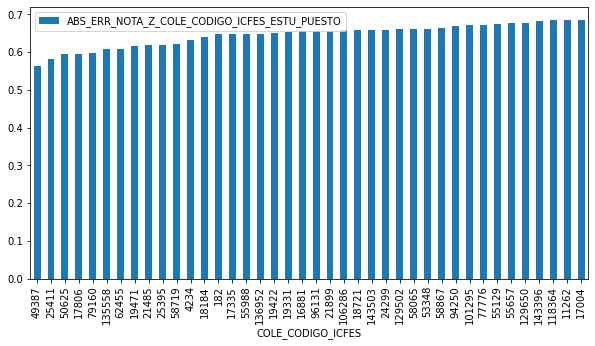

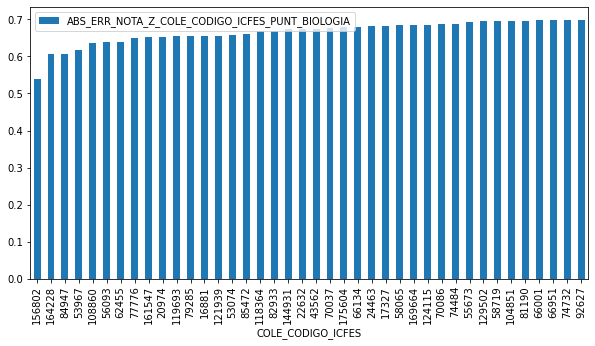

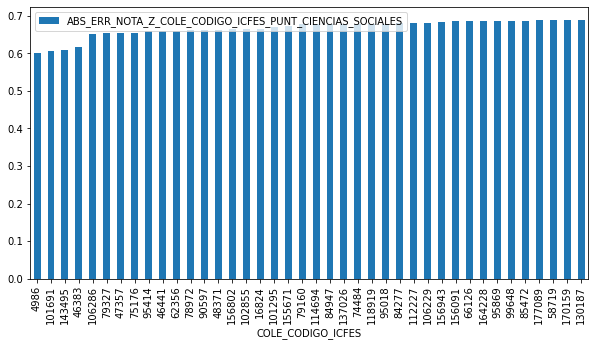

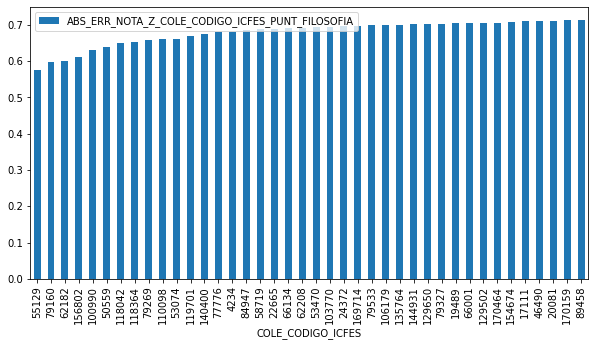

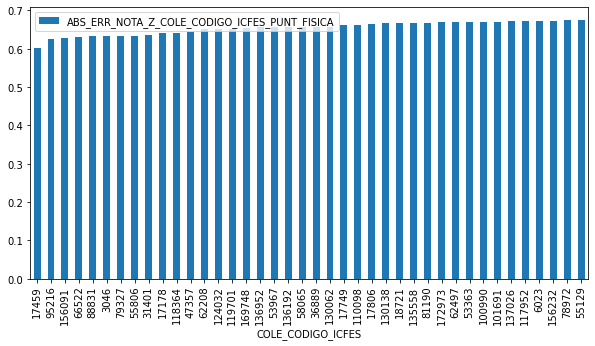

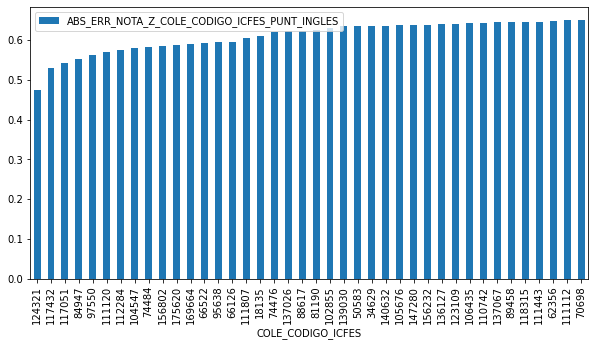

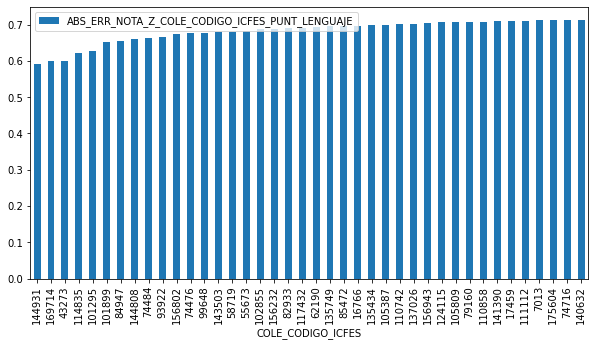

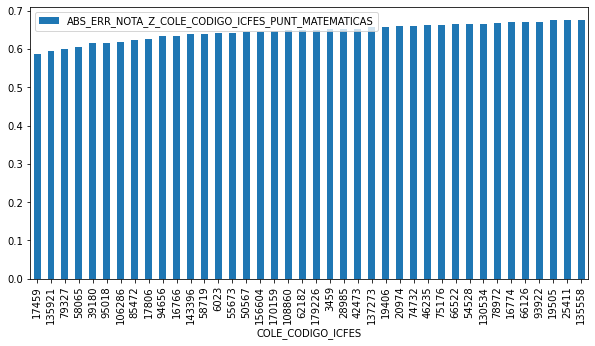

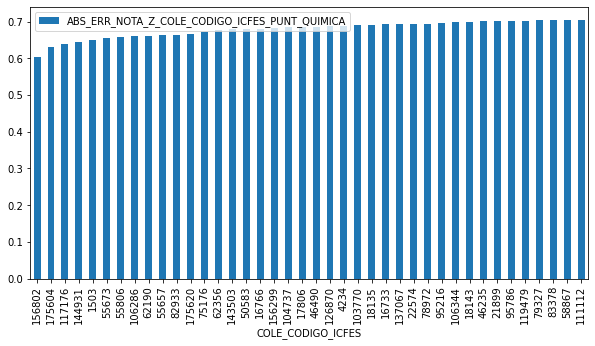

In [22]:
for notasz_error in notasz_error_names:
    df=final_info[['COLE_CODIGO_ICFES', notasz_error]].groupby('COLE_CODIGO_ICFES').mean().dropna()
    df.sort_values(by=[notasz_error], inplace=True)
    df[:40].plot.bar(figsize=(10,5))